# Photon-to-axion coupling solver in the case of all constant quantities

#### **Introduction**

This notebook numerically integrates the photon-to-axion equation of motion in the case of all constant quantities. 

 **Differential "master" equation**

The photon-axion conversion physics is described by the following coupled first order ODES:

$$  \begin{cases}
        i A_\parallel'(z)  = \Delta_{\gamma a} (z) a(z) e^{-i \int_{z_i}^z (\Delta_a-\Delta_\parallel (z')) dz'} \\
         i a(z)  = \Delta_{\gamma a} (z) A_\parallel(z) e^{+i \int_{z_i}^z (\Delta_a-\Delta_\parallel (z')) dz'}
    \end{cases}$$
where the derivatives are taken with respect to the direction along which the photon travels, which we denote by $z$, and
$$\begin{cases}
        \Delta_\parallel(z) =\Delta_\gamma(z)=- \frac{1}{2\omega} \left(\frac{4\pi \alpha n_e(z)}{m_e}\right) = -\frac{m^2_\gamma(z)}{2\omega}, \\ 
        \Delta_{\gamma a}(z) = \frac{g_{a\gamma\gamma}}{2} B_T(z), \\
        \Delta_a = -\frac{m^2_a}{2\omega}. 
    \end{cases}$$

Because we are discussing the photon-to-axion case (and not the axion-to-photon case), we have the following initial conditions: 
$$  \begin{cases}
        |A_\parallel(z_i)|^2 = 1 \\
        a(z_i) = 0
    \end{cases} \, \, \, \, \text{and} \, \, \, \, a'(z_i) = -i \Delta_{a\gamma}(z_i).
$$

The two equations of motion can be merged in one equation as:

$$ \boxed{\ \ \ a'' (z) + \left[ i \left(\Delta_\parallel (z)-\Delta_a  \right) -\frac{\Delta'_{\gamma a}(z)}{\Delta_{\gamma a}(z)}\right] a'(z) +\Delta^2_{a\gamma} a(z) = 0 \ \ \ }$$

leaving unchanged the initial conditions. 

We will refer to this second-order ODE as the "master" equation to solve. 

Equivalently, we could also consider the second-order ODE master equation written with respect to $A_\parallel(z)$, namely: 

$$\boxed{ \, \, \,  A''_\parallel (z) + \left[ i \left(\Delta_a -\Delta_\parallel (z) \right) -\frac{\Delta'_{\gamma a}}{\Delta_{\gamma a}}\right] A'_\parallel(z) +\Delta^2_{a\gamma} (z) A_\parallel(z) = 0, \, \,\, }$$
where the initial conditions now read
$$  \begin{cases}
        |A_\parallel(z_i)|^2 = 1 \\
        a(z_i) = 0
    \end{cases} \, \, \, \text{and} \, \, \, A'_\parallel(z_i) =0. $$

    


----------------------------------------------------------------

We can work on this equation numerically in the following way


Rewriting the master equation keeping $\Delta_\parallel(z) - \Delta_a$ and working with $\tilde{z}$:

In the case we work with adimensional interval, we have

$$ \frac{d^2 a}{d\tilde{z}^2} + i \frac{\Delta_\parallel - \Delta_a}{\Delta_{a\gamma}} \frac{da}{d\tilde{z}} + a = 0$$


$$ a'(\tilde{z}_i) = -i.$$

Note here the usual factor $\gamma$, defined in the case constant magnetic field and linear density (LZ approzimation), is not defined because $\frac{d\Delta_\parallel}{dz} =0$.


By analytically solve this equation (diagonalizing the hamiltonian), the transition probability is found to be

$$P_{\gamma \rightarrow a} = \frac{(\Delta_{\gamma a} z)^2}{\left(\frac{\Delta_{osc}}{2} z\right)^2}\sin^2 \left(\frac{\Delta_{osc}}{2} z\right),$$
where 
$$\Delta_{osc} = \sqrt{(\Delta_a- \Delta_\parallel)^2 + 4\Delta^2_{\gamma a}}. $$

While in the case of resonance, $m^2_a = m^2_\gamma$,
$$ P^{\text{res}}_{\gamma \rightarrow a} = \sin^2\left(\Delta_{\gamma a} z. \right)$$

We can test not only the differences between the analytical and numerical probabilities, but also the ones for the solutions as well. Indeed, In the the case of all constant quantities, we have the following analytical solution: 

$$ a(z) =  \cos\vartheta\sin\vartheta \left(e^{-i \lambda_+ z} - e^{-i\lambda_- z} \right), $$

where

$$\vartheta = \frac{1}{2}\arctg{\left(\frac{2 \Delta_{\gamma a}}{\Delta_\parallel - \Delta_a} \right)}$$
$$\lambda_\pm  = \frac{\Delta_a + \Delta_\parallel \pm \Delta_{osc}}{2}.$$

---------------------------------

The units we want to use hereafter are the natural units, $c=\hbar = k_B = 1$, and therefore all the quantities are written as energy in $GeV$: $[g_{a\gamma \gamma}] = GeV^{-1}$, $[m_a] = [m_e] = [m_\gamma] = GeV$, $[\omega] = GHz$, $[B] = \mu G$. 

-------------------------------

#### **General solver**


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_ivp, ode
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
import math


#OdeintW - wrapper to solve ODE with complex terms.
import odeintw 
from odeintw import odeintw


# Visual settings
%config InlineBackend.figure_format='retina'
%matplotlib inline

if '/Library/TeX/texbin/' not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
    
# Latex font
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import colors
plt.rcParams['figure.figsize'] = [9,7]  # Adjust the size as needed for the plots
from mpl_toolkits.mplot3d import Axes3D

In [2]:
####################################
# Natural unit conversions
####################################

#We express all the quantities in eV
GeV = 1 
MeV = 1e-3
keV = 1e-6
eV  = 1e-9
meV = 1e-12 

#Units:
Kg     = 5.609 * 1e35 * eV
meter  = 5.07 * 1e6 * eV**-1
cm     = 1e-2 * meter
Km     = 1e3 * meter
Mpc    = 1.564 * 1e29 * eV**-1
second = 1.5192 * 1e15 * eV**-1
Hz     = 1/second


Gauss  = 1.95 * 1e-2 * eV**2
Joule  = 6.242 * 1e18 * eV  

#Constants
AlphaEM           = 1/137
H_0               = 67.66 * Km/second / Mpc
ElementaryCharge  = np.sqrt(4 * np.pi * AlphaEM);
mass_electron     = 9.109 * 1e-31 * Kg
mass_proton       = 1.672 * 1e-27 * Kg
numerical_density = 1/cm**3


In [3]:
#How to return back to IS: 
#1) Take the expression of a quantity 
#2) Multiply it for the inverse of its own unities. 

#Some examples of conversion: 
 
print('H_0 in natural units is', H_0 , 'eV')
print('H_0 in IS units is', 1.4429776887871855e-33 * (Km/second / Mpc)**-1, 'Km/s/Mpc')

print('The electron mass in natural units is', mass_electron , 'eV')
print('The electron mass in IS units is', 510923.81000000006 * Kg**-1, 'Kg' )

print('The speed of light c in natural units is', 1)
print('The speed of light c in IS units is', 1 *(Km/second)**-1, 'Km/s')

print('The reduced Planck constant in natural units is', 1)
print('The reduced Planck constant in IS units is', 1 * (Joule * second)**-1, 'J * s')


H_0 in natural units is 1.4437375506559516e-42 eV
H_0 in IS units is 67624389473.68421 Km/s/Mpc
The electron mass in natural units is 0.0005109238100000001 eV
The electron mass in IS units is 9.109000000000001e-22 Kg
The speed of light c in natural units is 1
The speed of light c in IS units is 299644.9704142012 Km/s
The reduced Planck constant in natural units is 1
The reduced Planck constant in IS units is 1.0545356929961453e-34 J * s


In [4]:
########################################
# Interval of integration
########################################

zmin  = -1  #Here we work in units of Delta_ag Mpc for z, meaning we are working with \tilde{z} = Delta_{ag} Mpc. 
zmax  = 1
z_num = 1000001
z_thr = np.linspace(zmin, zmax, z_num) 
z_res =  z_clust =  z_thr[500000] 
z_res


0.0

In [5]:
########################################
# Specify parameters of the model
########################################

m_a   = 3e-13 * eV# Axion mass in eV
g_agg = 1e-10 * (GeV)**-1 # Axion photon-coupling in (GeV)^-1
nu    = 145 * 10**9 * Hz # Frequency in Hz 
omega = 2.*np.pi*nu # Angular frequency in Hz



In [6]:
########################################
# Specify functions of the model in the case of constant magnetic field and linear electron numerical density
########################################

#Note: we decided to work with \Delta_a and \Delta_\parallel defined without the minus sign. It is totally equivalent and the solution does not change.

def Delta_a(z):
    """
    Axion mass term
    Delta_a = -m_a^2/(2*omega)
    """
    return m_a**2/(2*omega) 


def n_e(z):
    """
    Numerical density of electrons
    given by the halo model
    """
    return   (m_a**2 * mass_electron/(ElementaryCharge)**2 ) #resonance on the whole interval 
    #return   2.5 * 1e-3 * numerical_density #resonance never happens.


def m2_g(z):
    """
    Effective mass of the photon
    acquired by scattering with free electrons
    """
    return   ElementaryCharge**2 * 1/mass_electron * n_e(z) #in eV units 


def B_T(z):
    """
    Transverse magnetic field
    """
    return  1 * 1e-6 * Gauss  #in \mu G 


def Delta_parallel(z):
    """
    Photon mass term
    Delta_parallel = -m^2_\gamma(z)/2\omega
    """
    return m2_g(z) /(2* omega)



def Delta_ag(z):
    """
    Axion-photon coupling term
    Delta_{a\gamma} = g_{a\gamma\gamma}/2 B_T(z)
    """
    return g_agg/2 * B_T(z)


def Delta_osc(z): 
    return np.sqrt((Delta_a(z) - Delta_parallel(z))**2 + 4 * (Delta_ag(z))**2)


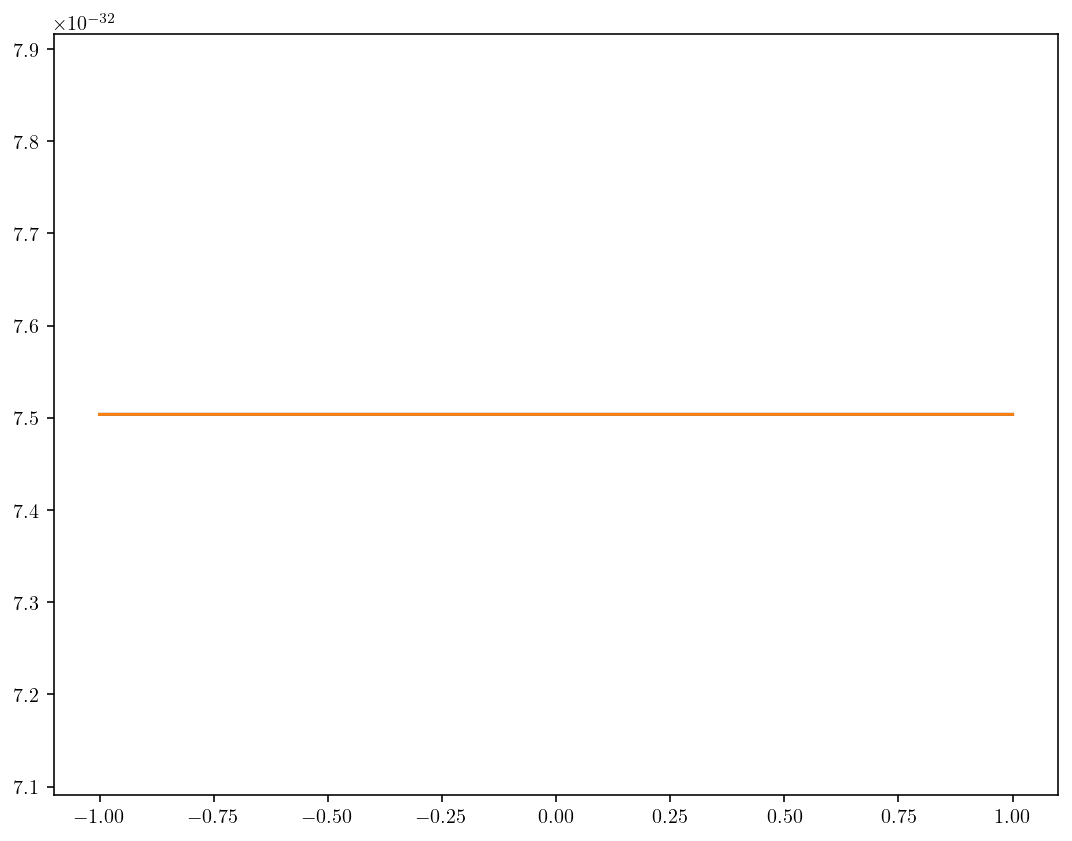

In [7]:
#Plotting Delta_parallel and Delta_a to check if resonance happens. 

plt.plot(z_thr, Delta_parallel(z_thr)* np.ones_like(z_thr))
plt.plot(z_thr, Delta_a(z_thr)* np.ones_like(z_thr))

To solve the second-order differential equation numerically we need to define a system reducing the latter in two first order ODE. 
We define 
$$ f= \frac{da}{d\tilde z}$$
and then, e.g. for the first working case,
$$ \begin{cases} 
f = \frac{da}{d\tilde z} \\
f' = - i \frac{\Delta_\parallel (z) - \Delta_a(z)}{\Delta_{a\gamma}} -a
\end{cases} \ \ \ \ \ \text{with} \ \ \ \ \ \text{IC}: \begin{cases}
f_i = -i\\ 
a_i =0
\end{cases}$$

**Note on the numerical solver:**

Here we present to way of integrating numerically the equation: with the wrapper odeintw (wrapper for odeint able to solve the ode with complex quantities) and with solve_ivp. In the case of solve_ivp you are able to chose the numerical integration method, e.g. RK45 and DOP853. We noted that with DOP853 (which is the Runge-Kupta numerical integration up to the 8th order) the solution is understimated, meaning it has the same form but it is translated along the y axis. 

 intdy--  t (=r1) illegal        
      in above message,  r1 = -0.9999960000000D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 = -0.9999960000000D+00   r2 = -0.9959831410455D+00


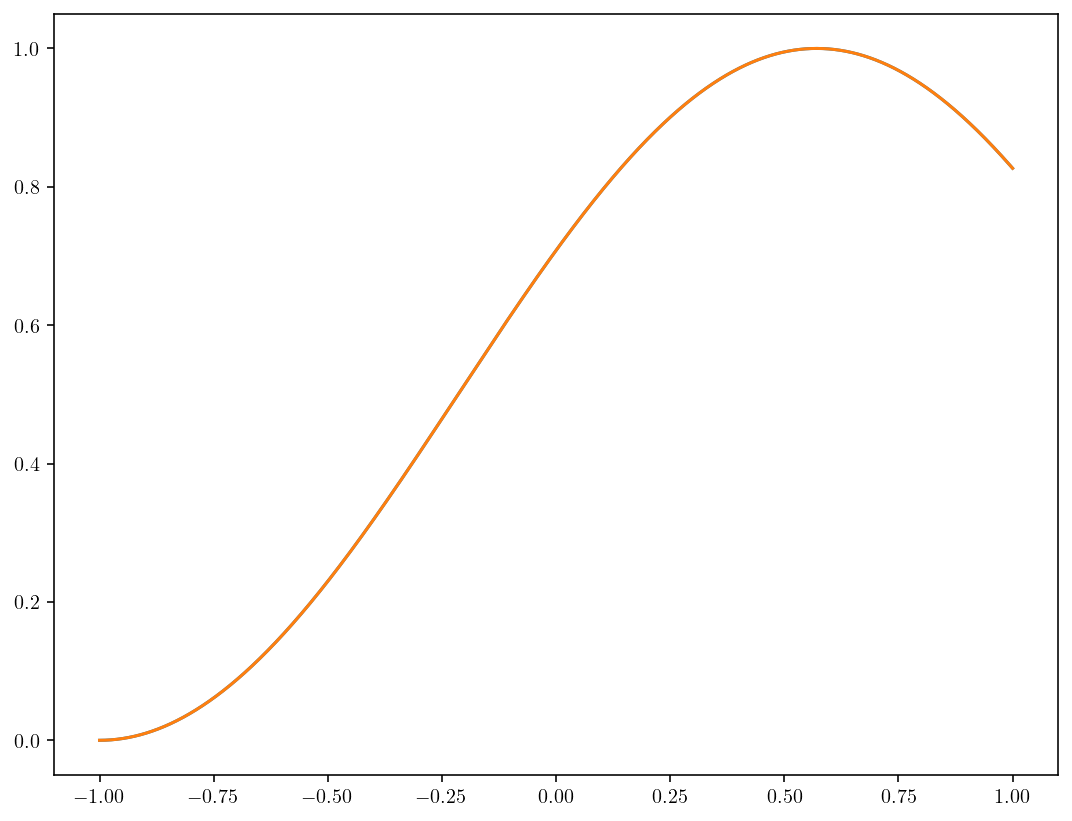

In [9]:
########################################
# Solving the differential equation in the three working ways listed above
########################################

#Defining the solvers:

#In the case of resonance use this solver
def master_eq_all_const_res(S,z): #Note: in the case you want to solve with solve_ivp, use (z,S) instead of (S,z)
    """ Master equation """
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j * (Delta_parallel(z) - Delta_a(z))/(Delta_ag(z)) * f  - ax]
    return np.array(dSdz, dtype=np.complex128)

#In the case of resonance never happens, use this other reparametrization, in units of \Delta_{z} 
#The previous one works but the adopted parametrization is not properly good for this case.
def master_eq_all_const_nores(S,z): #Note: in the case you want to solve with solve_ivp, use (z,S) instead of (S,z)
    S = np.asarray(S, dtype=np.complex128)
    ax, f = S
    dSdz = [f, -1j * (Delta_parallel(z) - Delta_a(z))/(Delta_osc(z) ) * f  -(Delta_ag(z)/Delta_osc(z))**2 *ax]
    return np.array(dSdz, dtype=np.complex128)




#Initial values
z_init = z_thr[0]
ic_all_const_res = np.array([ 0, -1j ], dtype=np.complex128)
ic_all_const_nores = np.array([ 0, -1j * Delta_ag(z_init)/Delta_osc(z_init)], dtype=np.complex128)
 


# Solving the ODE (solve_ivp method commented)
sol_all_const = odeintw(master_eq_all_const_res, ic_all_const_res, z_thr) #sol_all_const =solve_ivp(master_eq_all_const_res, (z_thr[0], z_thr[-1]), ic_LZ, method='RK45', t_eval=z_thr)
#sol_all_const =  odeintw(master_eq_all_const_nores, ic_all_const_nores, z_thr) #solve_ivp(master_eq_all_const_nores, (z_thr[0], z_thr[-1]), ic_all_const_nores, method='RK45', t_eval=z_thr)



#Squaring to obtain the probability
p_all_const =  np.abs(sol_all_const[:,0])**2  #np.abs(sol_all_const.y[0])**2

#Analytical solution in the case of resonance never happens
P_analytical_all_const_no_res = (Delta_ag(z_thr))**2 / (Delta_osc(z_thr) / 2 )**2 * ( np.sin( (z_thr)/2) )**2



#Plotting the solution and comparison with the analytical solution
plt.plot(z_thr, p_all_const)
plt.plot(z_thr, np.sin((z_thr-zmin))**2) #In the case resonance holds on the whole interval
#plt.plot(z_thr-1, P_analytical_all_const_no_res) ##In the case resonance does not happen

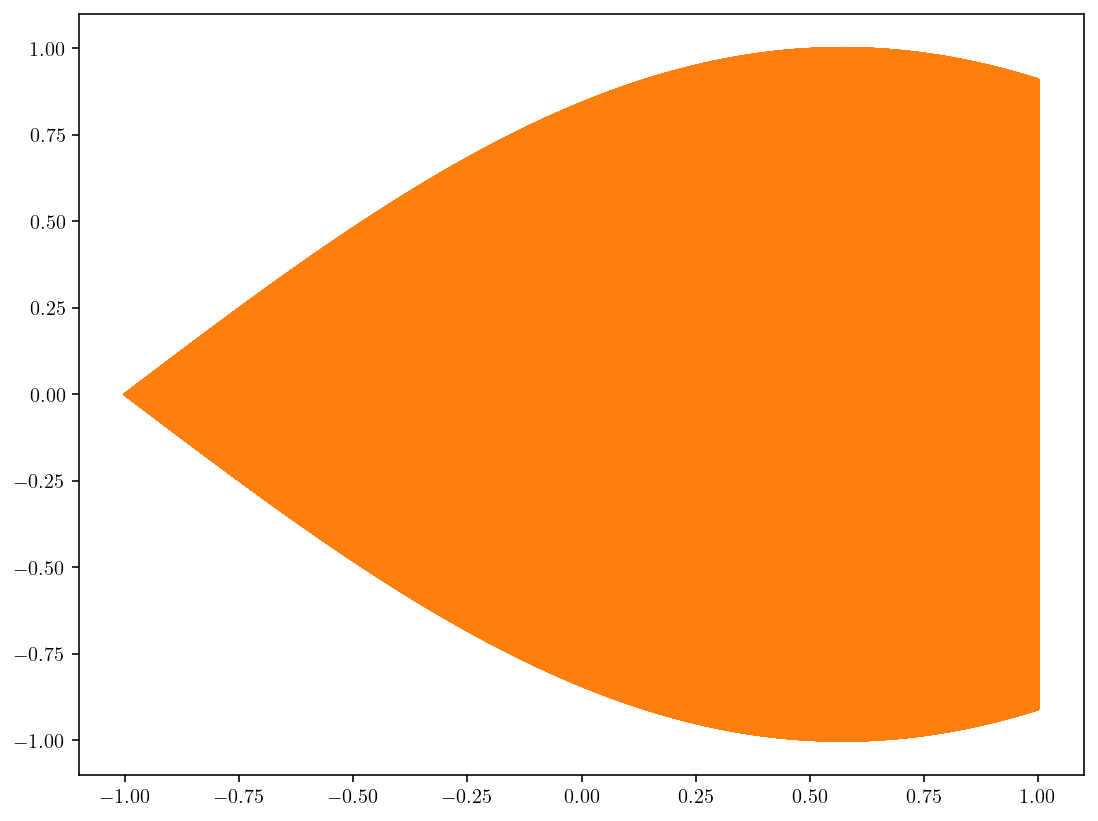

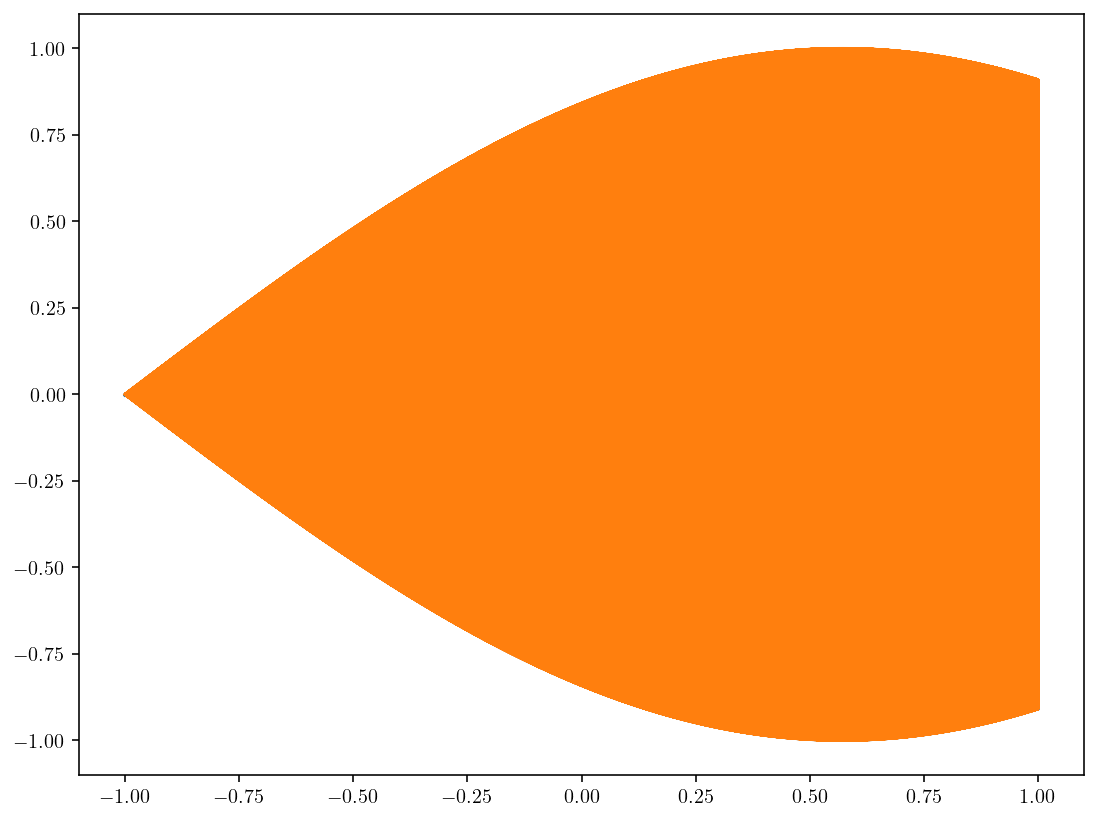

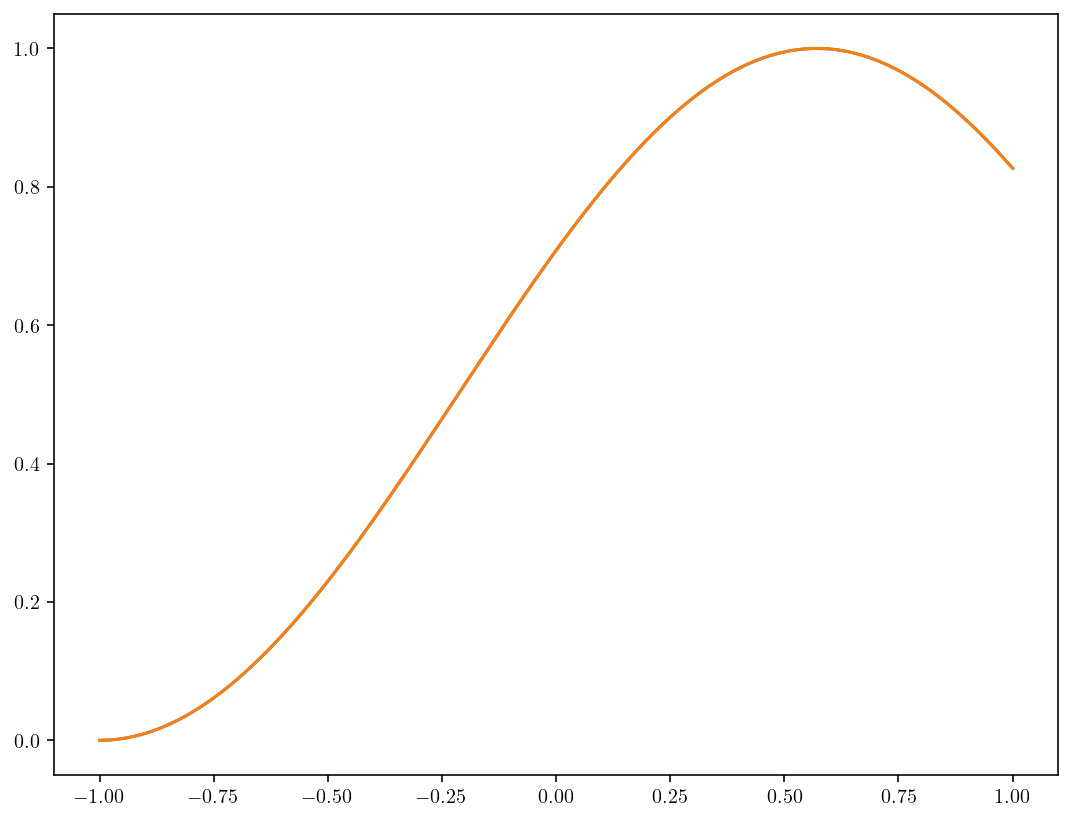

In [10]:
num_sol_all_const = sol_all_const[:,0]

#Analytical solution
theta =1/2 * np.arctan( (2* Delta_ag(z_thr)) / (Delta_parallel(z_thr) - Delta_a(z_thr)) )
lambda_plus = (Delta_a(z_thr) + Delta_parallel(z_thr) + Delta_osc(z_thr))/2
lambda_min = (Delta_a(z_thr) + Delta_parallel(z_thr) - Delta_osc(z_thr))/2

ana_sol_all_const = np.cos(theta) * np.sin(theta) * (np.exp(-1j * lambda_plus * (z_thr-zmin)/Delta_ag(z_thr)  )-np.exp(-1j * lambda_min * (z_thr-zmin)/Delta_ag(z_thr)  ) ) #In the case of resonance 
#ana_sol_all_const = np.cos(theta) * np.sin(theta) * (np.exp(-1j * lambda_plus * (z_thr-zmin)/Delta_osc(z_thr)  )-np.exp(-1j * lambda_min * (z_thr-zmin)/Delta_osc(z_thr) ) ) #In the case resonance does not happen

#Testing the differences between the two solutions

#Real part
plt.figure()
plt.plot(z_thr, num_sol_all_const.real)
plt.plot(z_thr, ana_sol_all_const.real)


#Imaginary part
plt.figure()
plt.plot(z_thr, num_sol_all_const.imag)
plt.plot(z_thr, ana_sol_all_const.imag)

#Abs squared
plt.figure()
plt.plot(z_thr, np.abs(num_sol_all_const)**2)
plt.plot(z_thr, np.abs(ana_sol_all_const)**2)